# Import necessary modules

In [1]:
# Modules to ignore warnings
import warnings               
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os   
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call

W0713 15:53:04.139219 140735649198976 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical,Sequence


Using TensorFlow backend.


# Reading Data

In [3]:
class_map = {'c0': 'safe driving',
            'c1': 'texting - right',
            'c2': 'talking on the phone - right',
            'c3': 'texting - left',
            'c4': 'talking on the phone - left'
            }

In [4]:
train_path = 'data/train'   
val_path = 'data/validation'       
classes = os.listdir(train_path)

print(classes)

['c0', 'c1', 'c3', 'c4', 'c2']


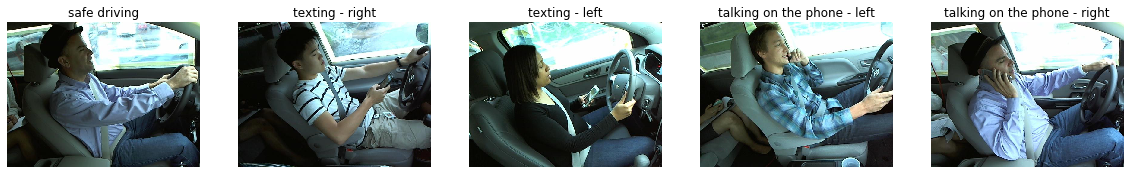

In [5]:
plt.figure(figsize=(20,6))
for ix,i in enumerate(classes):
    f = os.listdir(os.path.join(train_path,i))[0]
    img = mpimg.imread(os.path.join(train_path,i,f))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_map[i])

# Image Augmentation

In [6]:

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest') 

In [7]:
aug_images_path = 'preview'
f = os.listdir(os.path.join(train_path,classes[4]))[0]
img_path = os.path.join(train_path,classes[4],f)
img = load_img(img_path)       
x = img_to_array(img)          # this is a Numpy array with shape (480, 640, 3)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 480, 640, 3)

if os.path.isdir(aug_images_path):
    shutil.rmtree(aug_images_path)
    
os.system('mkdir '+aug_images_path)
    
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir=aug_images_path, save_prefix='c0', save_format='jpg'):
    i += 1
    if i > 9:
        break  

Text(0.5, 1.0, 'Original Image: img_513.jpg')

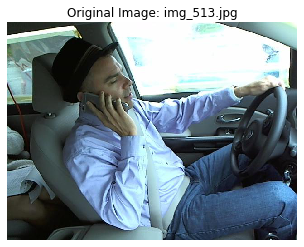

In [8]:
plt.imshow(img)
plt.axis('off')
plt.title('Original Image: '+f)

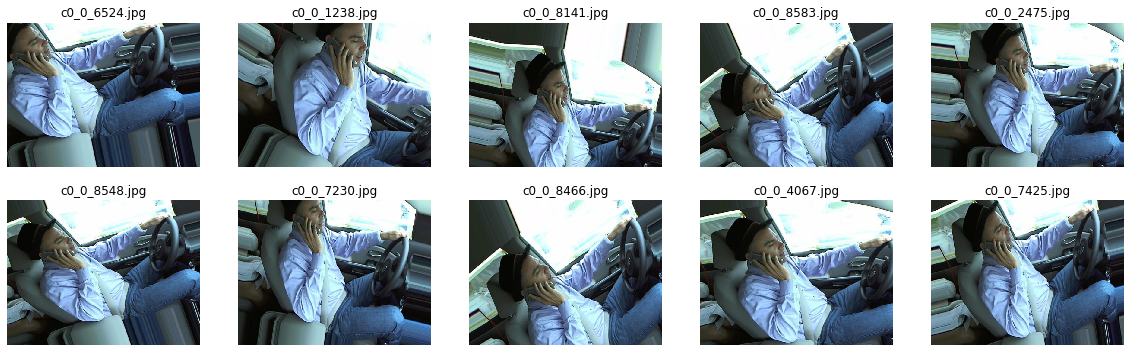

In [9]:
# Plot the augmented images for the above original image
plt.figure(figsize=(20,6))
aug_images = os.listdir('preview')
for ix,i in enumerate(aug_images):
    img = mpimg.imread(os.path.join('preview',i))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    if ix==10:
        break

# Data Generator

In [10]:
#  augmentation configuration for training
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    height_shift_range=0.2,
                                    zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(directory=train_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    target_size=(224,224))

Found 120 images belonging to 5 classes.


In [11]:
# augmentation configuration for validation
val_datagen = ImageDataGenerator(rescale=1/255.)
val_generator = train_datagen.flow_from_directory(directory=val_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=False, 
                                                    target_size=(224,224))

Found 45 images belonging to 5 classes.


# CNN for Image Classification

In [12]:
#MODEL
def image_classifier(nb_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=(224, 224, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(128, init='uniform', activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return(model)

In [13]:
# MODEL init
model = image_classifier(nb_classes=5)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
# model.fit returns the history of loss and metrics for train and validation datasets.

hist0 = model.fit_generator(train_generator, 
                           validation_data=val_generator, 
                           epochs=20,
                           steps_per_epoch=120/64.0,validation_steps=45/64.0,).history

Epoch 1/20
2/1 [================================] - 70s 35s/step - loss: 10.5900 - acc: 0.2143 - val_loss: 12.7889 - val_acc: 0.1778
Epoch 2/20
2/1 [================================] - 40s 20s/step - loss: 11.8676 - acc: 0.2195 - val_loss: 12.8636 - val_acc: 0.1778
Epoch 3/20
2/1 [================================] - 32s 16s/step - loss: 12.3829 - acc: 0.1919 - val_loss: 12.2172 - val_acc: 0.2000
Epoch 4/20
2/1 [================================] - 30s 15s/step - loss: 12.7320 - acc: 0.1744 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 5/20
2/1 [================================] - 35s 17s/step - loss: 12.6591 - acc: 0.2071 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 6/20
2/1 [================================] - 30s 15s/step - loss: 12.5140 - acc: 0.2158 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 7/20
2/1 [================================] - 30s 15s/step - loss: 13.2481 - acc: 0.1759 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 8/20


# Transfer Learning

In [15]:
# Inception was trained on 299x299x3 size images. Therefore we'll use the same dimentions for out task.
# Nevertheless, in transfer learning, if we are importing only the convolution layers, we can resize the images to other resolutions as well
# Inception is a fairly big network. Hence we used batch size as 64. 
# If larger memory GPUs are available, bigger batch_size could be used.

train_datagen = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    height_shift_range=0.2,
                                    zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    target_size=(299,299))

Found 120 images belonging to 5 classes.


In [16]:
val_datagen = ImageDataGenerator(rescale=1/255.)
val_generator = train_datagen.flow_from_directory(directory=val_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=False, 
                                                    target_size=(299,299))

Found 45 images belonging to 5 classes.


In [17]:
# Get Inception architecture from keras.applications
from keras.applications.inception_v3 import InceptionV3

def inception_tl(nb_classes, freez_wts):
    
    trained_model = InceptionV3(include_top=False,weights='imagenet')
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    pred_inception= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_inception)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    return(model)

In [18]:
model = inception_tl(nb_classes=5, freez_wts=False)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
hist1 = model.fit_generator(train_generator, 
                           validation_data=val_generator, 
                           epochs=20,
                           steps_per_epoch=120/64.0,validation_steps=45/64.0,).history

87916544/87910968 [==============================] - 13s 0us/step
Epoch 1/20
2/1 [================================] - 202s 101s/step - loss: 1.5040 - acc: 0.3570 - val_loss: 2.6802 - val_acc: 0.4889
Epoch 2/20
2/1 [================================] - 152s 76s/step - loss: 0.9230 - acc: 0.6854 - val_loss: 0.3822 - val_acc: 0.8222
Epoch 3/20
2/1 [================================] - 127s 64s/step - loss: 0.3086 - acc: 0.9164 - val_loss: 2.7146 - val_acc: 0.7111
Epoch 4/20
2/1 [================================] - 92s 46s/step - loss: 0.0844 - acc: 0.9760 - val_loss: 2.7336 - val_acc: 0.6444
Epoch 5/20
2/1 [================================] - 83s 42s/step - loss: 0.0583 - acc: 0.9913 - val_loss: 1.0473 - val_acc: 0.7778
Epoch 6/20
2/1 [================================] - 83s 41s/step - loss: 0.1030 - acc: 0.9658 - val_loss: 0.1371 - val_acc: 0.9333
Epoch 7/20
2/1 [================================] - 79s 39s/step - loss: 0.0389 - acc: 0.9825 - val_loss: 1.4898 - val_acc: 0.7111
Epoch 8/20
2/

Text(0.5, 1.0, 'Accuracy')

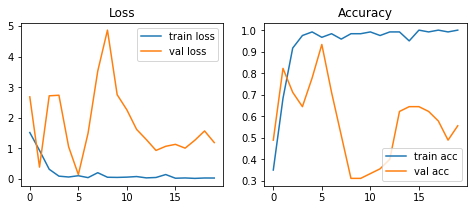

In [19]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
train_loss = plt.plot(hist1['loss'], label='train loss')
val_loss = plt.plot(hist1['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(hist1['acc'], label='train acc')
val_loss = plt.plot(hist1['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')

## Learning Rate Scheduler

In [45]:
model = inception_tl(nb_classes=5, freez_wts=False)
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)

In [46]:
nb_epochs = 10
init_lr = 0.001
min_lr = 0.000001
f = 10**(np.log10(min_lr/init_lr)/float(nb_epochs))

def poly_decay(epoch):
    ''' This function takes the current epoch as input and return the updated learning rate.
        The learning rate is multiplied by a factor 'f' after each epoch.
        In the first epoch, learning rate is set to 'init_lr'.
        By the end of 'nb_epochs' the learning rate is reduced to 'min_lr' '''
    return(init_lr*(f**epoch))


chkp = ModelCheckpoint(filepath='inception_dd.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)
lr_schedule = LearningRateScheduler(poly_decay)

Text(0.5, 1.0, 'Learning Rate over Epochs')

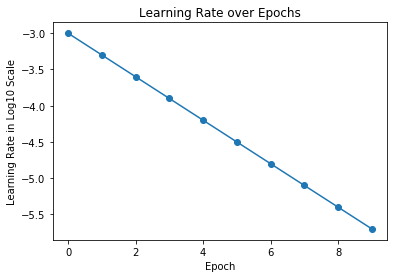

In [47]:
lr_list = [poly_decay(i) for i in range(nb_epochs)]
plt.scatter(range(nb_epochs), np.log10(lr_list))
plt.plot(np.log10(lr_list))
plt.xlabel('Epoch')
plt.ylabel('Learning Rate in Log10 Scale')
plt.title('Learning Rate over Epochs')

In [48]:
hist = model.fit_generator(train_generator, 
                           validation_data=val_generator, 
                           epochs=nb_epochs, 
                           callbacks=[chkp, lr_schedule],steps_per_epoch=120/64.0,validation_steps=45/64.0,).history
np.savez('inception_dd_history.npz', loss=hist['loss'], acc=hist['acc'], val_loss=hist['val_loss'], val_acc=hist['val_acc'])

Epoch 1/10
2/1 [================================] - 111s 55s/step - loss: 1.5232 - acc: 0.3508 - val_loss: 1.7129 - val_acc: 0.5778
Epoch 2/10
2/1 [================================] - 90s 45s/step - loss: 0.5505 - acc: 0.8284 - val_loss: 0.5852 - val_acc: 0.7111
Epoch 3/10
2/1 [================================] - 95s 48s/step - loss: 0.1630 - acc: 0.9506 - val_loss: 0.1604 - val_acc: 0.9333
Epoch 4/10
2/1 [================================] - 93s 47s/step - loss: 0.0723 - acc: 0.9666 - val_loss: 0.0991 - val_acc: 0.9556
Epoch 5/10
2/1 [================================] - 85s 43s/step - loss: 0.0483 - acc: 0.9913 - val_loss: 0.0237 - val_acc: 1.0000
Epoch 6/10
2/1 [================================] - 86s 43s/step - loss: 0.0324 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 1.0000
Epoch 7/10
2/1 [================================] - 87s 44s/step - loss: 0.0164 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 8/10
2/1 [================================] - 89s 44s/step - loss: 0.0185 - 

Text(0.5, 1.0, 'Accuracy')

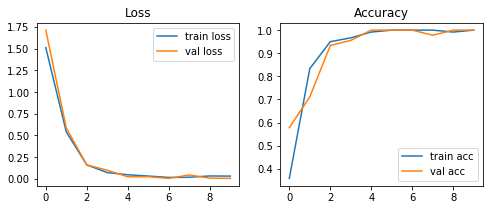

In [49]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
train_loss = plt.plot(hist['loss'], label='train loss')
val_loss = plt.plot(hist['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(hist['acc'], label='train acc')
val_loss = plt.plot(hist['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')

## Predictions

In [53]:
val_preds = model.predict_generator(generator=val_generator,steps=45/64.0,)

In [54]:
val_preds_class = val_preds.argmax(axis=1)
val_preds_df = pd.DataFrame({'image':val_generator.filenames, 'prediction':val_preds_class})
val_preds_df.head(10)

,image,prediction
0,c0/img_1005.jpg,0
1,c0/img_104.jpg,0
2,c0/img_139.jpg,0
3,c0/img_208.jpg,0
4,c0/img_231.jpg,0
5,c0/img_262.jpg,0
6,c0/img_292.jpg,0
7,c0/img_34.jpg,0
8,c0/img_981.jpg,0
9,c1/img_1045.jpg,1


In [55]:
val_generator.class_indices

{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4}

## Incorrect Predictions

In [59]:
val_incorrect_pred = [i for i in val_preds_df.index.values if int(val_preds_df.image.values[i].split('/')[0][1])!=val_preds_df.prediction.values[i]]
# val_incorrect_pred = [i for i,j in zip(val_preds_df.image.values,val_preds_df.prediction.values) if int(i.split('/')[0][1])!=j]

In [60]:
val_incorrect_pred

[]

In [61]:
plt.figure(figsize=(20,4))
plt.suptitle("Incorrect Predictions", size=32)
for ix,i in enumerate(val_incorrect_pred):
    img = mpimg.imread(os.path.join('val',val_preds_df.image[i]))
    plt.subplot(1,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Pred: '+class_map['c'+str(val_preds_df.prediction[i])]+'\n'+'Actual: '+class_map[val_preds_df.image[i].split('/')[0]])
    if ix==4:
        break

<Figure size 1440x288 with 0 Axes>